In [1]:
import torch
import torchani
from torchani.datasets import ANIDataset
from torchani.units import hartree2kcalmol
from torchani.utils import PERIODIC_TABLE
import ase
from ase import io
from ase.optimize import BFGS
from ase.visualize import view

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from pathlib import Path

In [2]:
def tensors_from_xyz(path):
    with open(path, 'r') as f:
        lines = f.readlines()
        num_atoms = int(lines[0])
        coordinates = []
        species = []
        element, a, b, c = lines[2].split()
        cell = torch.diag(torch.tensor([float(a), float(b), float(c)]))
        for line in lines[2:]:
            values = line.split()
            if values:
                s = values[0].strip()
                x = float(values[1])
                y = float(values[2])
                z = float(values[3])
                coordinates.append([x, y, z])
                species.append(PERIODIC_TABLE.index(s))
        coordinates = torch.tensor(coordinates)
        species = torch.tensor(species, dtype=torch.long)
        assert coordinates.shape[0] == num_atoms
        assert species.shape[0] == num_atoms
    return species, coordinates



def covariances(atomic_energies):
    atomic_energies = atomic_energies.squeeze()
    cov = np.cov(atomic_energies,rowvar=False)
    atomic_variances = cov.diagonal()
    av_sum = atomic_variances.sum()
    atomic_stdev = np.sqrt(atomic_variances)
    estimated_qbc = np.sqrt(sum(sum(cov)))/np.sqrt(len(atomic_variances))
    
    just_covariances = estimated_qbc - np.sum(atomic_variances)
    
    qbc = atomic_energies.sum(1).std(0,ddof=1)/np.sqrt(len(atomic_variances)) # TorchANI uses unbiased stdev, so N-1
    
    
    assert math.isclose(qbc, estimated_qbc, abs_tol=0.0002) # Tolerance set to agree within 0.0002 Hartree (~.12 kcal/mol))

    print('(1) Atomic energy variance', '(2) Covariances', '(3) QBC')
    
    return av_sum, just_covariances, qbc

device = torch.device('cpu')
model = torchani.models.ANI2x(periodic_table_index=True).double().to(device)
calculator = model.ase()

/home/nick/TorchANI_sandbox/torchani/models.py:103: UserWarning: The default is now to accept atomic numbers as indexes, do not set periodic_table_index=True. if you need to accept raw indices set periodic_table_index=False
  warnings.warn("The default is now to accept atomic numbers as indexes,"


In [3]:
ds_path = Path('/home/nick/First_DSs/ANI-1x-first-conformers.h5')

ds = ANIDataset(locations=ds_path, names='1x first')
device = torch.device('cpu')
ani2x = torchani.models.ANI2x().double()
calculator = torchani.models.ANI2x().ase()

In [4]:
ch4_species = ds['CH4']['species']
ch4_coord =   ds['CH4']['coordinates']

In [5]:
ase_ch4 = ase.Atoms(numbers=ch4_species[0],positions=ch4_coord[0])
ase_ch4.calc = calculator

dyn = BFGS(ase_ch4)
dyn.run(fmax=0.05)

ch4_coord = torch.tensor(ase_ch4.positions[None])
ch4 = (ch4_species, ch4_coord)

print(ch4)

      Step     Time          Energy         fmax
BFGS:    0 14:02:03    -1101.652213        5.4868
BFGS:    1 14:02:03    -1101.950568        1.6234
BFGS:    2 14:02:03    -1101.991349        0.8651
BFGS:    3 14:02:03    -1102.020865        0.5139
BFGS:    4 14:02:03    -1102.038562        0.4610
BFGS:    5 14:02:03    -1102.044180        0.1599
BFGS:    6 14:02:03    -1102.045011        0.0669
BFGS:    7 14:02:03    -1102.045153        0.0287
(tensor([[6, 1, 1, 1, 1]]), tensor([[[-4.0070e-04,  2.3968e-02,  4.7165e-02],
         [-9.1394e-01, -4.9023e-01, -2.5943e-01],
         [-2.1275e-01,  6.5072e-01,  9.1682e-01],
         [ 3.6179e-01,  6.4846e-01, -7.7358e-01],
         [ 7.6282e-01, -7.1464e-01,  3.0179e-01]]], dtype=torch.float64))


In [6]:
ani2x.atomic_energies(ch4,average=False,with_SAEs=False).energies.sum(1).std(0)

tensor([0.0127, 0.0032, 0.0032, 0.0032, 0.0032], dtype=torch.float64,
       grad_fn=<StdBackward0>)

In [7]:
ani2x.members_energies(ch4)

SpeciesEnergies(species=tensor([[1, 0, 0, 0, 0]]), energies=tensor([[-40.4996],
        [-40.4996],
        [-40.4995],
        [-40.4995],
        [-40.4994],
        [-40.4996],
        [-40.4993],
        [-40.4989]], dtype=torch.float64, grad_fn=<SumBackward1>))

In [8]:
ch4_ae = hartree2kcalmol(ani2x.atomic_energies(ch4,average=False,with_SAEs=False).energies.squeeze().detach().numpy())
print(ch4_ae)

[[-4.4662088  -1.81769753 -1.8550468  -1.83293238 -1.82837369]
 [15.04878223 -6.69132998 -6.73309343 -6.70482921 -6.70445862]
 [ 1.65660765 -3.34035486 -3.36851078 -3.34972141 -3.34908964]
 [-8.19718763 -0.86519423 -0.90449344 -0.88280946 -0.87589589]
 [-7.85609803 -0.93847027 -0.9842329  -0.9575911  -0.95146229]
 [ 6.75534981 -4.61774645 -4.65925725 -4.6326473  -4.63030816]
 [-1.68297526 -2.47555527 -2.5136185  -2.49033133 -2.48668149]
 [-4.09943838 -1.80392114 -1.84909055 -1.82394491 -1.81631639]]


In [9]:
ch4_ae.shape

(8, 5)

In [11]:
ch4_ae.sum(1).std(0,ddof=0)

0.12488663583789662

In [11]:
hartree2kcalmol(ani2x.energies_qbcs(ch4).qbcs.item()*math.sqrt(5))
# Equal up to float rounding precision

0.13350942956799672

In [12]:
print(covariances(ch4_ae))

(1) Atomic energy variance (2) Covariances (3) QBC
(79.18599413722475, -79.12628690519395, 0.05970723203079201)


[[ 63.19041427 -15.89838638 -15.89416677 -15.88323588 -15.90162548]
 [-15.89838638   4.00099055   3.99984412   3.99712732   4.00178674]
 [-15.89416677   3.99984412   3.99872852   3.99599707   4.00064803]
 [-15.88323588   3.99712732   3.99599707   3.99327559   3.99792655]
 [-15.90162548   4.00178674   4.00064803   3.99792655   4.0025852 ]]
Sum of AE stdev:
 15.948133969265562
Sum of covariances (off-diagonal elements):
 -15.814624539696347
QBC from ANI (w/o dividing by N_atoms):
 0.13350942956799672 (kcal/mol)
Sqrt of the sum over entire covariance matrix:
 0.13350942956921585 (kcal/mol)


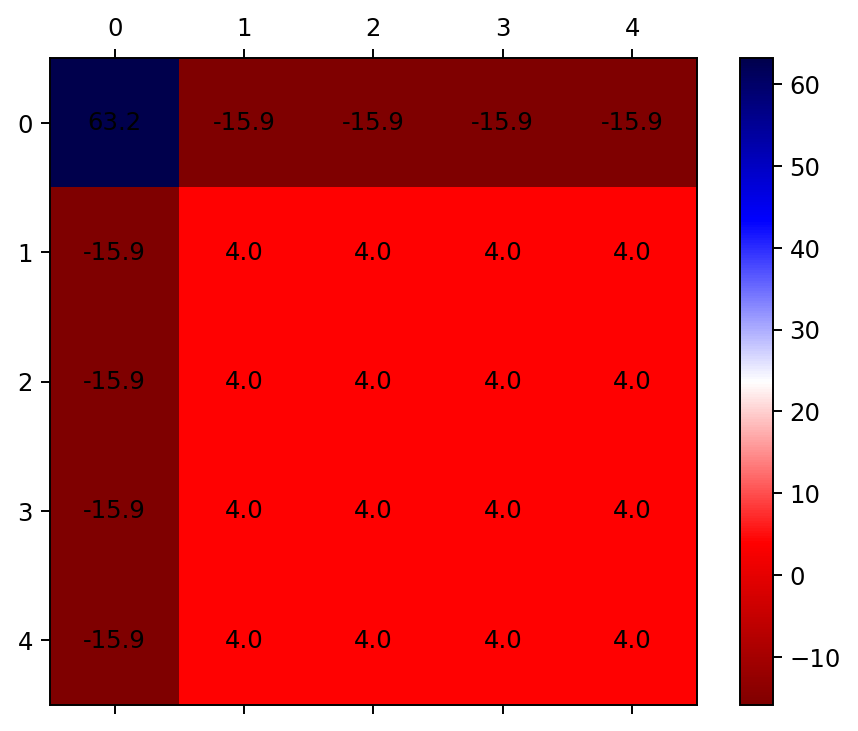

In [15]:
ch4_cov = np.cov(ch4_ae,rowvar=False)
print(ch4_cov)
#print('Covariance matrix:\n',pd.DataFrame(ch4_cov))
atomic_variances = ch4_cov.diagonal()
atomic_stdev = np.sqrt(atomic_variances)
#print()
#print('AE variance (stdev squared):\n',atomic_variances)
print('Sum of AE stdev:\n',np.sum(atomic_stdev))
#print()

sqrt_sum_cov = np.sqrt(sum(sum(ch4_cov)))
ch4_qbc = hartree2kcalmol(ani2x.members_energies(ch4)[1].std(0).detach().numpy()[0])
only_covariances = sqrt_sum_cov - np.sum(atomic_stdev)

print('Sum of covariances (off-diagonal elements):\n',only_covariances)

print('QBC from ANI (w/o dividing by N_atoms):\n',ch4_qbc,'(kcal/mol)')
print('Sqrt of the sum over entire covariance matrix:\n',sqrt_sum_cov,'(kcal/mol)')

plt.rcParams['figure.dpi'] = 175

fig, ax = plt.subplots()
img = ax.matshow(ch4_cov, cmap='seismic_r')
fig.colorbar(img)

for (i, j), z in np.ndenumerate(ch4_cov):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', fontweight=500)

In [24]:
ch4_cov

array([[ 0.10070034, -0.02533569, -0.02532897, -0.02531155, -0.02534085],
       [-0.02533569,  0.00637598,  0.00637416,  0.00636983,  0.00637725],
       [-0.02532897,  0.00637416,  0.00637238,  0.00636803,  0.00637544],
       [-0.02531155,  0.00636983,  0.00636803,  0.00636369,  0.0063711 ],
       [-0.02534085,  0.00637725,  0.00637544,  0.0063711 ,  0.00637853]])

In [2]:
hartree2kcalmol(0.00021276145856287095/math.sqrt(5))

0.05970741152337919

In [51]:
print('Mol_E stdev:',ani2x.energies_qbcs(ch4).qbcs.item()*math.isqrt(5))
print('Atom_E stdev:',torch.tensor(ch4_ae).std(0, unbiased=True))
print('Sum of AE_std:',torch.tensor(ch4_ae).std(0, unbiased=True).sum(0))
print()
print('Covariance matrix:\n',cov(ch4_ae))
print('Diagonal of cov matrix:\n',(cov(ch4_ae).diagonal())) # This gives "variances"


Mol_E stdev: 0.00019029963373543365
Atom_E stdev: tensor([0.0127, 0.0032, 0.0032, 0.0032, 0.0032], dtype=torch.float64)
Sum of AE_std: tensor(0.0254, dtype=torch.float64)

Covariance matrix:
 [[ 1.12333322e-03 -2.82624944e-04 -2.82549934e-04 -2.82355571e-04
  -2.82682503e-04]
 [-2.82624944e-04  7.11254475e-05  7.11050677e-05  7.10567597e-05
   7.11395954e-05]
 [-2.82549934e-04  7.11050677e-05  7.10852361e-05  7.10366677e-05
   7.11193529e-05]
 [-2.82355571e-04  7.10567597e-05  7.10366677e-05  7.09882766e-05
   7.10709617e-05]
 [-2.82682503e-04  7.11395954e-05  7.11193529e-05  7.10709617e-05
   7.11537837e-05]]
Diagonal of cov matrix:
 [1.12333322e-03 7.11254475e-05 7.10852361e-05 7.09882766e-05
 7.11537837e-05]
